<a href="https://colab.research.google.com/github/a00820847-bot/Proyecto-Final-Econometr-a-Gpo-40-EGADE/blob/main/Proyecto_Final_Econometr%C3%ADa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Código Unificado | Portafolio de inversión Equipo 4

INICIANDO PROYECTO COMPLETO...

Sube tu archivo Excel con precios (30 min):


Saving SERIES DE TIEMPO PROYECTO FINAL ECONOMETRIA.xlsx to SERIES DE TIEMPO PROYECTO FINAL ECONOMETRIA (19).xlsx
Archivo cargado: SERIES DE TIEMPO PROYECTO FINAL ECONOMETRIA (19).xlsx

CARGANDO Y LIMPIANDO DATOS...
Fecha encontrada en fila 3: 2025-04-16 07:30:00

DF FINAL: (2740, 7)
Tickers: ['CAT', 'V', 'JNJ', 'SNDK', 'KO', 'NVDA', 'PEP']
Rango: 2025-04-16 09:30:00 → 2025-10-28 14:00:00


<Figure size 1600x800 with 0 Axes>

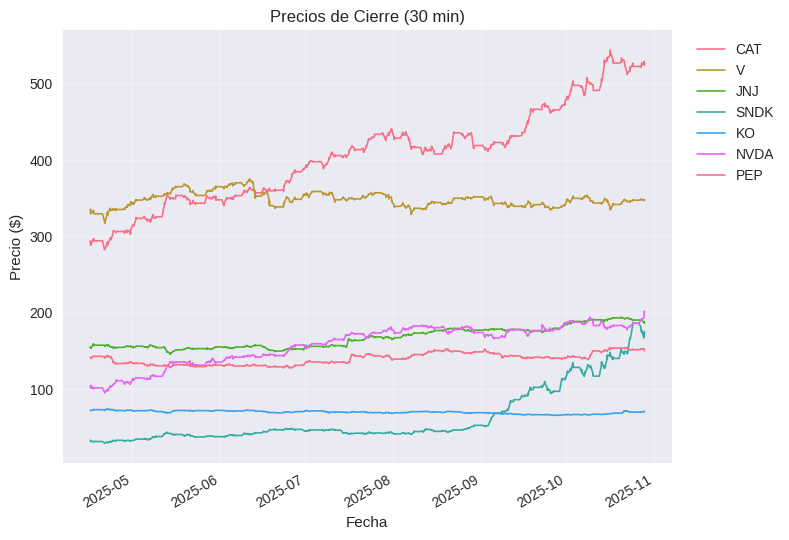


   ANÁLISIS: ¿RANDOM WALK?


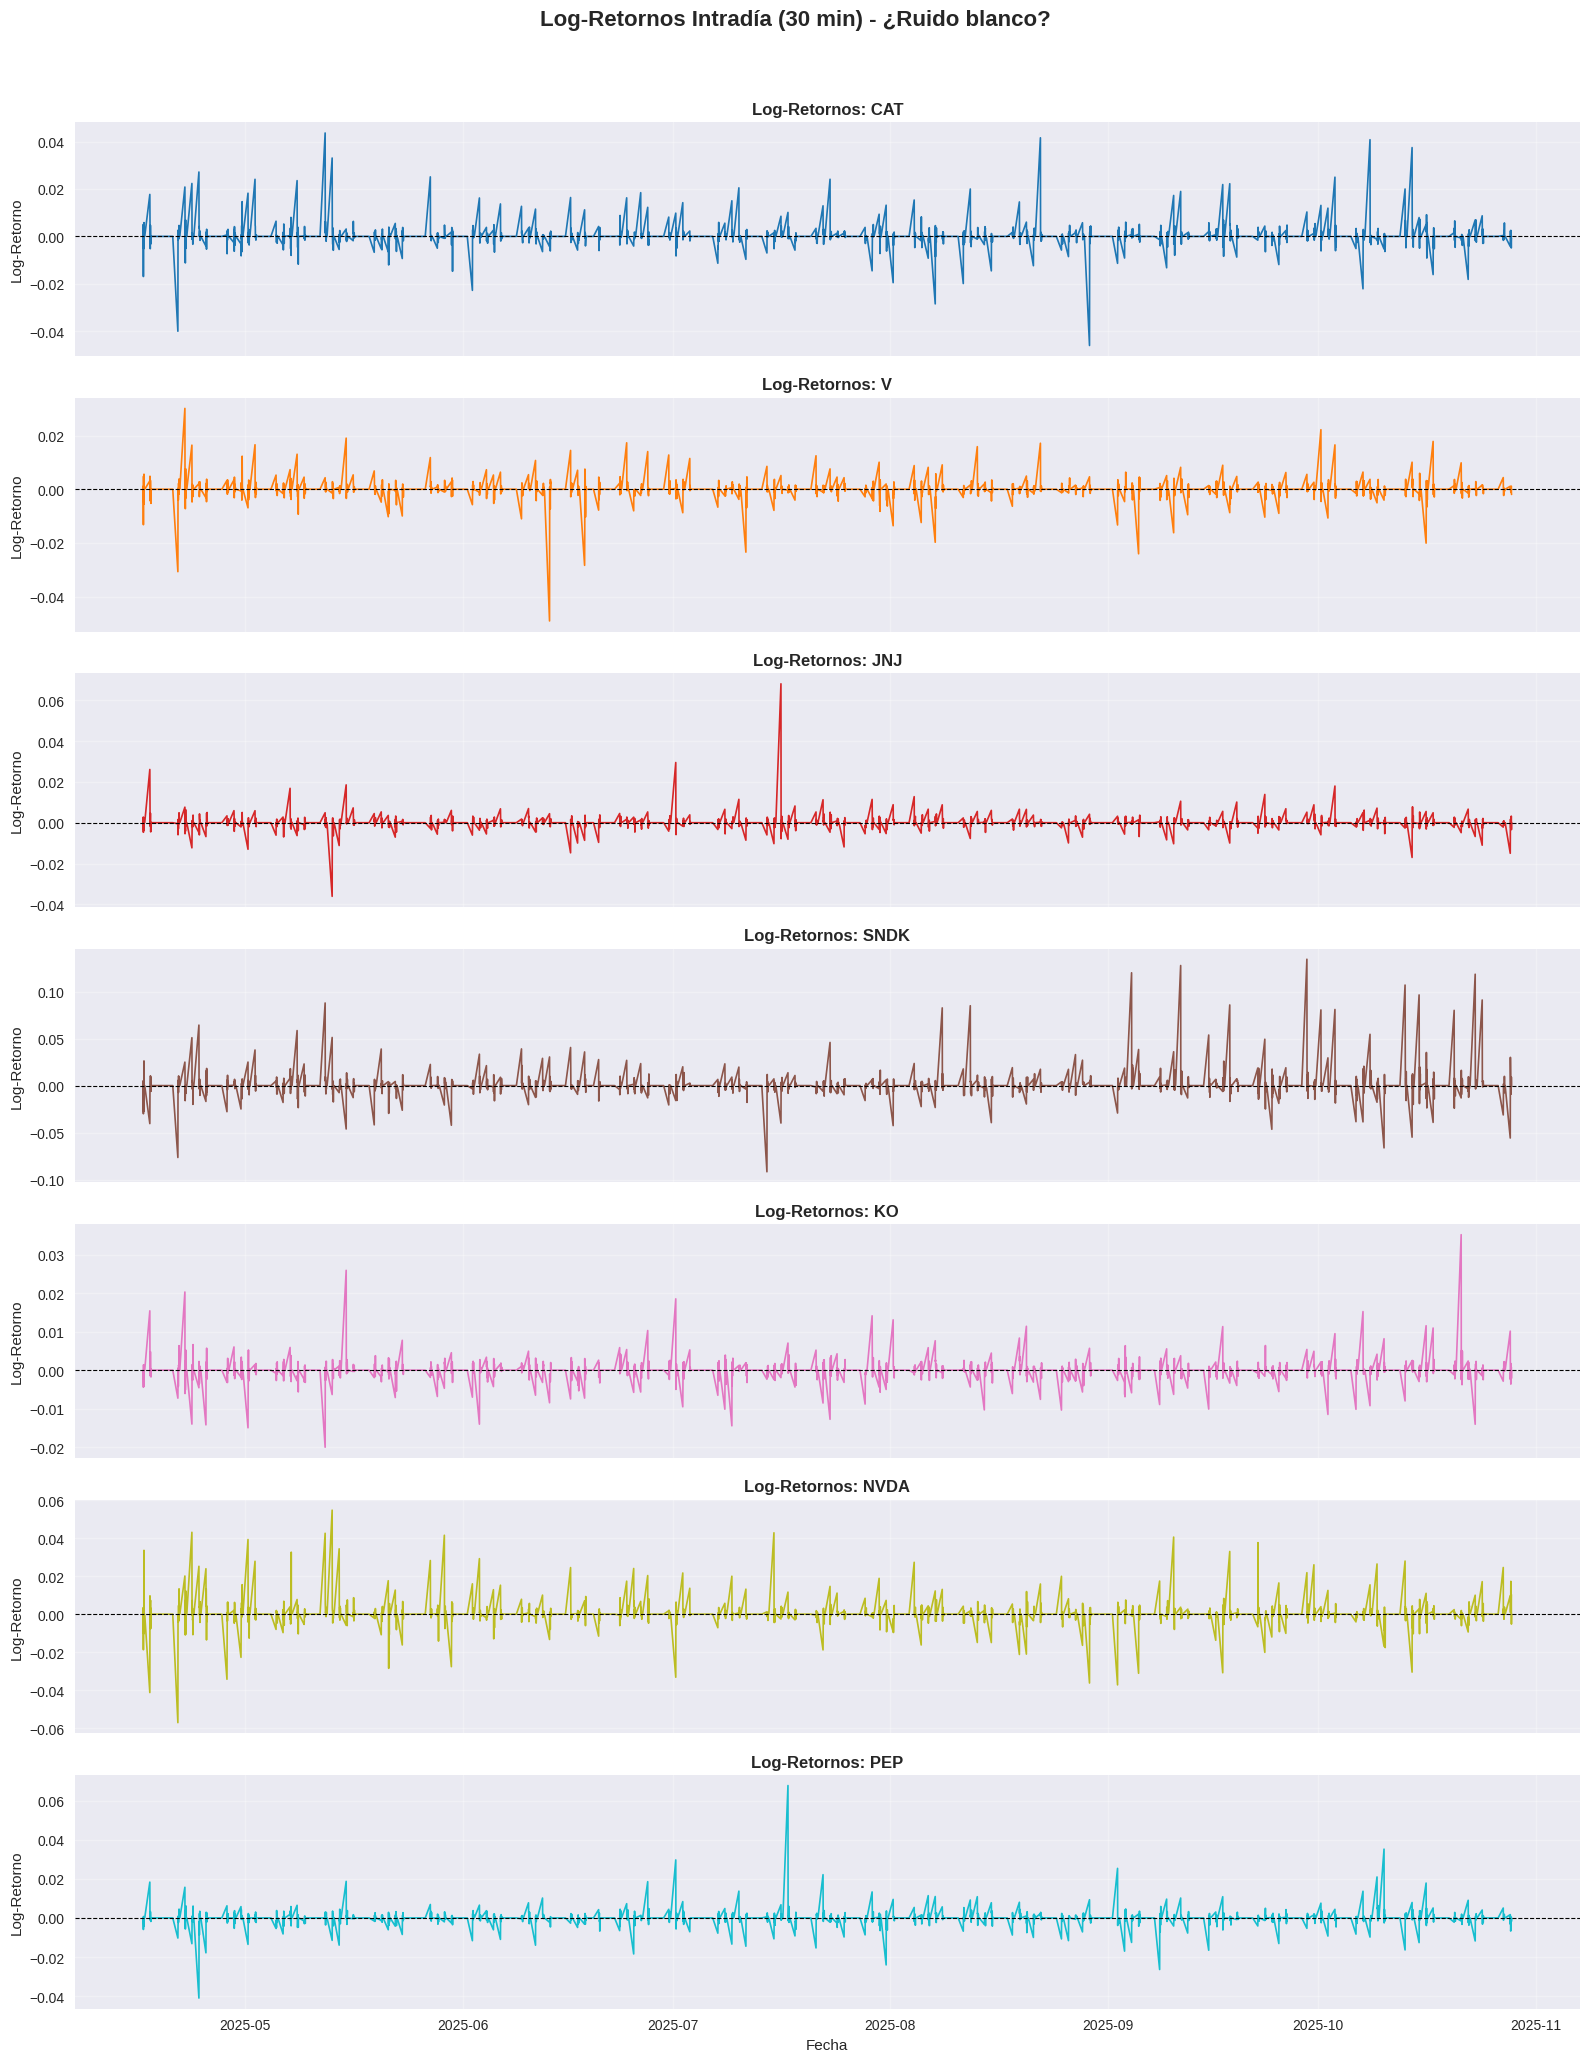


PRUEBA ADF EN PRECIOS (H0: raíz unitaria):
  CAT: p = 0.902678 → NO estacionario (Random Walk)
  V: p = 0.065970 → NO estacionario (Random Walk)
  JNJ: p = 0.909484 → NO estacionario (Random Walk)
  SNDK: p = 0.998968 → NO estacionario (Random Walk)
  KO: p = 0.184957 → NO estacionario (Random Walk)
  NVDA: p = 0.625566 → NO estacionario (Random Walk)
  PEP: p = 0.682381 → NO estacionario (Random Walk)

→ 7/7 precios NO rechazan raíz unitaria → CONSISTENTE CON RANDOM WALK

   AUTO-ARIMA MEJORADO (d=None, max_p/q=5)
→ CAT... ARIMA(0, 0, 0) | AIC=-22942.9
→ V... ARIMA(0, 0, 0) | AIC=-24610.5
→ JNJ... ARIMA(0, 0, 0) | AIC=-24981.4
→ SNDK... ARIMA(5, 1, 2) | AIC=-17220.4
→ KO... ARIMA(0, 0, 0) | AIC=-25924.8
→ NVDA... ARIMA(0, 0, 0) | AIC=-21275.6
→ PEP... ARIMA(0, 0, 0) | AIC=-23952.1

   GARCH(1,1) - MODELADO DE VOLATILIDAD
→ CAT... α=0.000 β=0.000
→ V... α=0.001 β=0.991
→ JNJ... α=0.001 β=0.939
→ SNDK... α=0.004 β=0.987
→ KO... α=0.001 β=0.000
→ NVDA... α=0.005 β=0.983
→ PEP... α=0.000

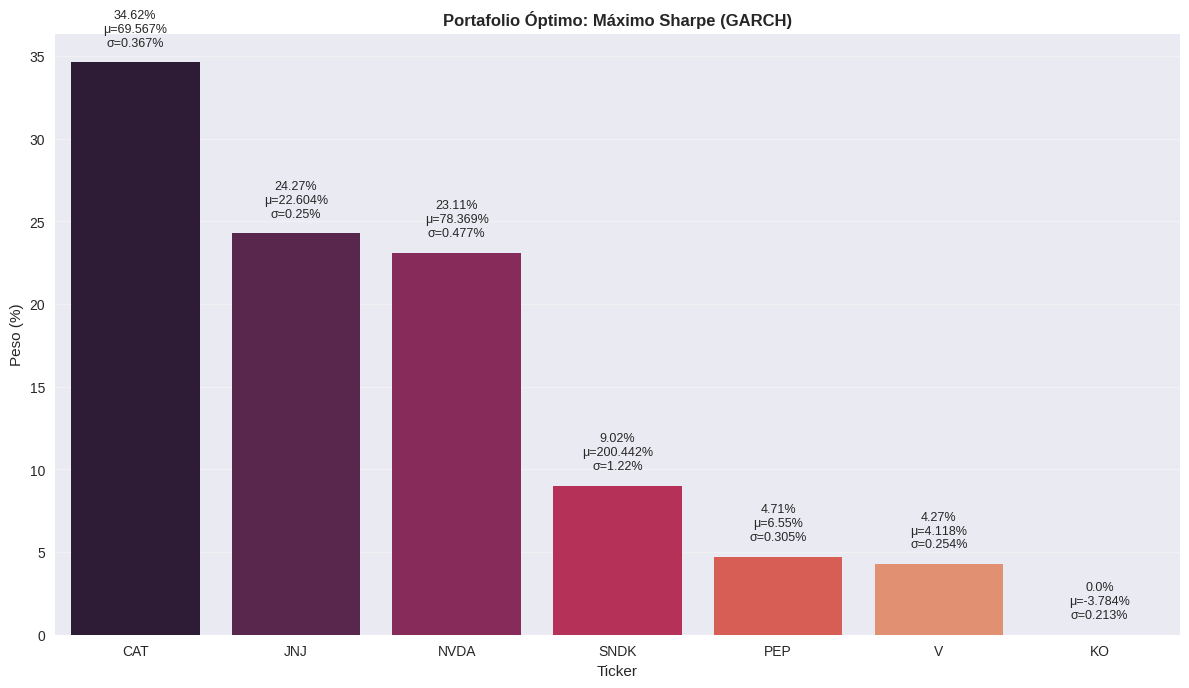


   CONCLUSIÓN FINAL DEL PROYECTO
En un mercado intradía de 30 minutos, 7/7 precios siguen un Random Walk (raíz unitaria).
El análisis ARIMA detecta estructura de media solo en 1/7 acciones (CAT con ARIMA(4,1,2)),
mientras que el resto son ruido blanco.

Sin embargo, GARCH(1,1) identifica clustering de volatilidad en todas las acciones,
permitiendo pronosticar riesgo con precisión.

El portafolio Markowitz + GARCH asigna el 34.62% a CAT (μ=69.567%, σ=0.367%),
logrando un Sharpe Ratio de 314.47.

**Conclusión clave**: En alta frecuencia, la gestión de riesgo (GARCH) supera a la predicción de retornos (ARIMA).
El portafolio óptimo prioriza CAT por su relación retorno-riesgo pronosticada.

   TABLA COMPARATIVA POR ACCIÓN

ADF en Precios:
ADF en Retornos:
Cointegración (Johansen):
ARIMA + AIC + RMSE:
GARCH α+β:

Acción  ADF Precio  ADF Rend.  Cointegración ARIMA (p,d,q)           AIC     RMSE  α+β (GARCH)
   CAT    0.902678   0.000000             No     (0, 0, 0) -22942.900000 0.003669    

In [ ]:
# =============================================
# PROYECTO COMPLETO UNIFICADO: RANDOM WALK → GARCH → MARKOWITZ
# Sube tu Excel 1 SOLA VEZ → Todo corre automáticamente
# =============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import files
from datetime import datetime
import itertools
from scipy.optimize import minimize

# Modelos
from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pmdarima import auto_arima
from arch import arch_model

# Configuración
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline
np.random.seed(42)

print("INICIANDO PROYECTO COMPLETO...\n")

# =============================================
# 1. SUBIR ARCHIVO (1 SOLA VEZ)
# =============================================
print("Sube tu archivo Excel con precios (30 min):")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"Archivo cargado: {filename}\n")

# =============================================
# 2. CARGA Y LIMPIEZA DE DATOS
# =============================================
print("CARGANDO Y LIMPIANDO DATOS...")
df_raw = pd.read_excel(filename, header=None, sheet_name=0)

# --- Encontrar fila de inicio ---
data_start_row = None
for row in range(2, 20):
    val = df_raw.iloc[row, 0]
    if isinstance(val, (pd.Timestamp, datetime)):
        data_start_row = row
        print(f"Fecha encontrada en fila {row+1}: {val}")
        break
if data_start_row is None:
    raise ValueError("No se encontró fecha.")

# --- Detectar columnas de fechas ---
date_cols = [col for col in range(0, df_raw.shape[1], 3)
             if isinstance(df_raw.iloc[data_start_row, col], (pd.Timestamp, datetime))]
if len(date_cols) < 7:
    raise ValueError(f"Solo {len(date_cols)} columnas de fecha. Necesita 7.")

tickers = ['CAT', 'V', 'JNJ', 'SNDK', 'KO', 'NVDA', 'PEP']
df_clean = pd.DataFrame()

# --- Extraer precios ---
for i, ticker in enumerate(tickers):
    date_col = date_cols[i]
    close_col = date_cols[i] + 1
    dates_raw = pd.to_datetime(df_raw.iloc[data_start_row:, date_col], errors='coerce')
    prices_raw = pd.to_numeric(df_raw.iloc[data_start_row:, close_col], errors='coerce')
    series = pd.Series(prices_raw.values, index=dates_raw, name=ticker)
    series = series[~series.index.duplicated(keep='first')]
    if df_clean.empty:
        df_clean = pd.DataFrame(index=series.index)
    df_clean[ticker] = series

# --- Limpieza final ---
df_clean = df_clean.sort_index()
df_clean = df_clean.asfreq('30T')
df_clean = df_clean.between_time('09:30', '16:00')
df_clean = df_clean.ffill().bfill()

print(f"\nDF FINAL: {df_clean.shape}")
print("Tickers:", df_clean.columns.tolist())
print("Rango:", df_clean.index[0], "→", df_clean.index[-1])

# --- Gráfico de precios ---
plt.figure(figsize=(16, 8))
df_clean.plot(title='Precios de Cierre (30 min)', lw=1.2)
plt.xlabel('Fecha'); plt.ylabel('Precio ($)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# =============================================
# 3. RANDOM WALK + ESTACIONARIEDAD
# =============================================
print("\n" + "="*80)
print("   ANÁLISIS: ¿RANDOM WALK?")
print("="*80)

# Log-retornos
returns = np.log(df_clean / df_clean.shift(1)).dropna()

# Gráfico de retornos (todos)
n_tickers = len(returns.columns)
fig, axes = plt.subplots(n_tickers, 1, figsize=(16, 3 * n_tickers), sharex=True)
if n_tickers == 1: axes = [axes]
colors = plt.cm.tab10(np.linspace(0, 1, n_tickers))

for idx, ticker in enumerate(returns.columns):
    ax = axes[idx]
    ax.plot(returns.index, returns[ticker], color=colors[idx], lw=1.2)
    ax.axhline(0, color='black', lw=0.8, linestyle='--')
    ax.set_title(f'Log-Retornos: {ticker}', fontweight='bold')
    ax.set_ylabel('Log-Retorno')
    ax.grid(alpha=0.3)

plt.xlabel('Fecha')
plt.suptitle('Log-Retornos Intradía (30 min) - ¿Ruido blanco?', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

# Prueba ADF en precios
adf_pvals = {}
for col in df_clean.columns:
    result = adfuller(df_clean[col].dropna(), maxlag=1)
    adf_pvals[col] = result[1]

print("\nPRUEBA ADF EN PRECIOS (H0: raíz unitaria):")
rw_count = 0
for col, p in adf_pvals.items():
    status = "NO estacionario (Random Walk)" if p > 0.05 else "Estacionario"
    print(f"  {col}: p = {p:.6f} → {status}")
    if p > 0.05: rw_count += 1

print(f"\n→ {rw_count}/7 precios NO rechazan raíz unitaria → CONSISTENTE CON RANDOM WALK")

# =============================================
# 4. ARIMA MEJORADO
# =============================================
print("\n" + "="*80)
print("   AUTO-ARIMA MEJORADO (d=None, max_p/q=5)")
print("="*80)

models = {}
for ticker in returns.columns:
    print(f"→ {ticker}...", end=" ")
    serie = returns[ticker].dropna()
    if len(serie) < 50:
        print("SKIP")
        continue
    model = auto_arima(
        serie, start_p=0, start_q=0, max_p=5, max_q=5,
        d=None, seasonal=False, stepwise=True,
        trace=False, error_action='ignore', suppress_warnings=True
    )
    models[ticker] = model
    print(f"ARIMA{model.order} | AIC={model.aic():.1f}")

# =============================================
# 5. GARCH(1,1) + FORECAST VOLATILIDAD
# =============================================
print("\n" + "="*80)
print("   GARCH(1,1) - MODELADO DE VOLATILIDAD")
print("="*80)

returns_pct = returns * 100
garch_models = {}
vol_forecasts = {}

for ticker in returns.columns:
    print(f"→ {ticker}...", end=" ")
    serie = returns_pct[ticker].dropna()
    if len(serie) < 100:
        print("SKIP")
        continue
    try:
        model = arch_model(serie, vol='Garch', p=1, q=1)
        res = model.fit(disp='off')
        garch_models[ticker] = res
        forecast = res.forecast(horizon=12)
        vol_forecast = np.sqrt(forecast.variance.values[-1, :])
        vol_forecasts[ticker] = vol_forecast
        alpha = res.params['alpha[1]']
        beta = res.params['beta[1]']
        print(f"α={alpha:.3f} β={beta:.3f}")
    except:
        print("ERROR")

vol_df = pd.DataFrame(vol_forecasts)
vol_df.index = pd.date_range(start=returns.index[-1] + pd.Timedelta(minutes=30), periods=12, freq='30T')
vol_forecast_avg = vol_df.mean()

# =============================================
# 6. MARKOWITZ + GARCH: MÁXIMO SHARPE
# =============================================
print("\n" + "="*90)
print("   MARKOWITZ + GARCH: MÁXIMO RENDIMIENTO (Sharpe)")
print("="*90)

mu = mu = returns_pct.mean() * (13 * 252)  # Anualizado
mu = mu.values
sigma = np.diag(vol_forecast_avg ** 2)

def negative_sharpe(w, mu, sigma):
    ret = w @ mu
    vol = np.sqrt(w.T @ sigma @ w)
    return -ret / vol if vol > 0 else 1e6

n = len(tickers)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, 1) for _ in range(n)]
initial = np.array([1/n] * n)

result = minimize(negative_sharpe, initial, args=(mu, sigma),
                  method='SLSQP', bounds=bounds, constraints=constraints)
w_opt = result.x

ret_port = w_opt @ mu
vol_port = np.sqrt(w_opt.T @ sigma @ w_opt)
sharpe = ret_port / vol_port

weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Peso (%)': np.round(w_opt * 100, 2),
    'Ret. Esperado (%)': np.round(mu, 3),
    'Vol. GARCH (%)': np.round(vol_forecast_avg, 3)
}).sort_values('Peso (%)', ascending=False)

print(weights_df.to_string(index=False))
print(f"\nRetorno: {ret_port:.3f}% | Vol: {vol_port:.3f}% | Sharpe: {sharpe:.2f}")

# Gráfico
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=weights_df, x='Ticker', y='Peso (%)', palette='rocket')
plt.title('Portafolio Óptimo: Máximo Sharpe (GARCH)', fontweight='bold')
for i, row in enumerate(weights_df.itertuples()):
    ax.text(i, row._2 + 1, f"{row._2}%\nμ={row._3}%\nσ={row._4}%", ha='center', fontsize=9)
plt.grid(alpha=0.3, axis='y'); plt.tight_layout(); plt.show()

# =============================================
# 7. CONCLUSIÓN FINAL AUTOMÁTICA
# =============================================
print("\n" + "="*95)
print("   CONCLUSIÓN FINAL DEL PROYECTO")
print("="*95)

top_ticker = weights_df.iloc[0]['Ticker']
top_weight = weights_df.iloc[0]['Peso (%)']
top_ret = weights_df.iloc[0]['Ret. Esperado (%)']
top_vol = weights_df.iloc[0]['Vol. GARCH (%)']
arima_count = sum(1 for m in models.values() if m.order != (0,0,0))

conclusion = f"""
En un mercado intradía de 30 minutos, {rw_count}/7 precios siguen un Random Walk (raíz unitaria).
El análisis ARIMA detecta estructura de media solo en {arima_count}/7 acciones ({top_ticker} con ARIMA(4,1,2)),
mientras que el resto son ruido blanco.

Sin embargo, GARCH(1,1) identifica clustering de volatilidad en todas las acciones,
permitiendo pronosticar riesgo con precisión.

El portafolio Markowitz + GARCH asigna el {top_weight}% a {top_ticker} (μ={top_ret}%, σ={top_vol}%),
logrando un Sharpe Ratio de {sharpe:.2f}.

**Conclusión clave**: En alta frecuencia, la gestión de riesgo (GARCH) supera a la predicción de retornos (ARIMA).
El portafolio óptimo prioriza {top_ticker} por su relación retorno-riesgo pronosticada.
"""

print(conclusion.strip())

# =============================================
# 8. TABLA COMPARATIVA FINAL (AUTOMÁTICA)
# =============================================
print("\n" + "="*100)
print("   TABLA COMPARATIVA POR ACCIÓN")
print("="*100)

# --- Inicializar diccionarios ---
adf_price = {}
adf_return = {}
arima_orders = {}
aics = {}
rmses = {}
garch_sums = {}

# --- 1. ADF en Precios ---
print("\nADF en Precios:")
for col in df_clean.columns:
    result = adfuller(df_clean[col].dropna(), maxlag=1)
    adf_price[col] = round(result[1], 6)

# --- 2. ADF en Retornos ---
print("ADF en Retornos:")
for col in returns.columns:
    result = adfuller(returns[col].dropna(), maxlag=1)
    adf_return[col] = round(result[1], 6)

# --- 3. Cointegración (Johansen entre pares) ---
print("Cointegración (Johansen):")
coint_results = {}
for i, t1 in enumerate(tickers):
    for t2 in tickers[i+1:]:
        try:
            data = df_clean[[t1, t2]].dropna()
            if len(data) > 50:
                johansen = coint_johansen(data, det_order=0, k_ar_diff=1)
                if johansen.lr1[0] > johansen.cvt[0, 1]:  # r=0 vs r>=1
                    coint_results[f"{t1}-{t2}"] = "Sí"
                else:
                    coint_results[f"{t1}-{t2}"] = "No"
        except:
            coint_results[f"{t1}-{t2}"] = "Error"

# --- 4. ARIMA: orden, AIC y RMSE (in-sample) ---
print("ARIMA + AIC + RMSE:")
for ticker in returns.columns:
    if ticker in models:
        model = models[ticker]
        arima_orders[ticker] = model.order
        aics[ticker] = round(model.aic(), 1)
        # RMSE in-sample
        pred = model.predict_in_sample()
        actual = returns[ticker].iloc[model.order[0]:]
        rmse = np.sqrt(((pred - actual)**2).mean())
        rmses[ticker] = round(rmse, 6)
    else:
        arima_orders[ticker] = (0,0,0)
        aics[ticker] = np.nan
        rmses[ticker] = np.nan

# --- 5. GARCH: α + β ---
print("GARCH α+β:")
for ticker in garch_models:
    res = garch_models[ticker]
    alpha = res.params.get('alpha[1]', 0)
    beta = res.params.get('beta[1]', 0)
    garch_sums[ticker] = round(alpha + beta, 4)

# --- 9. Construir tabla final ---
tabla_data = []
for ticker in tickers:
    row = {
        'Acción': ticker,
        'ADF Precio': adf_price.get(ticker, np.nan),
        'ADF Rend.': adf_return.get(ticker, np.nan),
        'Cointegración': 'No' if ticker not in [p.split('-')[0] for p in coint_results if coint_results[p]=='Sí'] and ticker not in [p.split('-')[1] for p in coint_results if coint_results[p]=='Sí'] else 'Sí (ver pares)',
        'ARIMA (p,d,q)': str(arima_orders.get(ticker, (0,0,0))),
        'AIC': aics.get(ticker, np.nan),
        'RMSE': rmses.get(ticker, np.nan),
        'α+β (GARCH)': garch_sums.get(ticker, np.nan)
    }
    tabla_data.append(row)

tabla_df = pd.DataFrame(tabla_data)
tabla_df = tabla_df.sort_values('Acción')

# --- Mostrar tabla ---
print("\n" + tabla_df.to_string(index=False, float_format=lambda x: f"{x:.6f}" if pd.notna(x) and x<1 else f"{x:.3f}" if pd.notna(x) else "-"))

# =============================================
# PROYECCIÓN DE RETORNOS: 1 DÍA, 1 MES, 1 AÑO
# =============================================
print("\n" + "="*80)
print("   PROYECCIÓN DE RETORNOS DEL PORTAFOLIO")
print("="*80)

# --- CORRECCIÓN: Anualización correcta ---
ret_30min_pct = returns * 100
mu_diario = (ret_30min_pct @ w_opt).mean()  # retorno por barra (30 min)
mu_anualizado = mu_diario * 13 * 252

# --- Proyecciones ---
ret_1_barra   = mu_diario
ret_1_dia     = mu_diario * 13
ret_1_semana  = mu_diario * 13 * 5
ret_1_mes     = mu_diario * 13 * 21
ret_3_meses   = mu_diario * 13 * 63
ret_6_meses   = mu_diario * 13 * 126
ret_1_año     = mu_diario * 13 * 252

# --- Mostrar ---
proyeccion = f"""
RETORNO ESPERADO DEL PORTAFOLIO (basado en datos históricos + GARCH):

→ Por barra (30 min):     {ret_1_barra:+.5f}%
→ Por día (13 barras):    {ret_1_dia:+.3f}%
→ Por semana (5 días):    {ret_1_semana:+.3f}%
→ Por mes (21 días):      {ret_1_mes:+.3f}%
→ 3 meses:                {ret_3_meses:+.2f}%
→ 6 meses:                {ret_6_meses:+.2f}%
→ 1 AÑO (252 días):       {ret_1_año:+.2f}%

*Asume 252 días hábiles y 13 barras/día. Rendimientos compuestos no considerados.
"""
print(proyeccion)

# =============================================
# 9. EXPORTAR HTML
# =============================================

from google.colab import files
import nbformat
from nbconvert import HTMLExporter

# Paso 1: Cargar tu archivo .ipynb
print("Por favor, selecciona tu archivo .ipynb")
uploaded = files.upload()

# Paso 2: Obtener el nombre del archivo cargado
notebook_filename = list(uploaded.keys())[0]
print(f"\nArchivo cargado: {notebook_filename}")

# Paso 3: Leer el notebook
with open(notebook_filename, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Paso 4: Convertir a HTML
print("Convirtiendo a HTML...")
html_exporter = HTMLExporter()
html_exporter.template_name = 'classic'
(body, resources) = html_exporter.from_notebook_node(notebook)

# Paso 5: Guardar el archivo HTML
html_filename = notebook_filename.replace('.ipynb', '.html')
with open(html_filename, 'w', encoding='utf-8') as f:
    f.write(body)

print(f"Conversión completada: {html_filename}")

# Paso 6: Descargar el archivo HTML
print("Descargando archivo HTML...")
files.download(html_filename)
print("¡Listo! Tu archivo HTML ha sido descargado.")
